In [1]:
# import necessary libraries


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
plt.rcParams.update({'font.size': 22})

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          652 non-null    object 
 1   Daily Confirmed                               652 non-null    int64  
 2   False Positives Found                         543 non-null    float64
 3   Cumulative Confirmed                          652 non-null    int64  
 4   Daily Discharged                              652 non-null    int64  
 5   Passed but not due to COVID                   652 non-null    int64  
 6   Cumulative Discharged                         652 non-null    int64  
 7   Discharged to Isolation                       652 non-null    int64  
 8   Still Hospitalised                            652 non-null    int64  
 9   Daily Deaths                                  652 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               652 non-null    int64  
 1   False Positives Found                         652 non-null    float64
 2   Cumulative Confirmed                          652 non-null    int64  
 3   Daily Discharged                              652 non-null    int64  
 4   Passed but not due to COVID                   652 non-null    int64  
 5   Cumulative Discharged                         652 non-null    int64  
 6   Discharged to Isolation                       652 non-null    int64  
 7   Still Hospitalised                            652 non-null    int64  
 8   Daily Deaths                                  652 non-null    int64  
 9   Cumulative Deaths                             652 non-null    int

<AxesSubplot:>

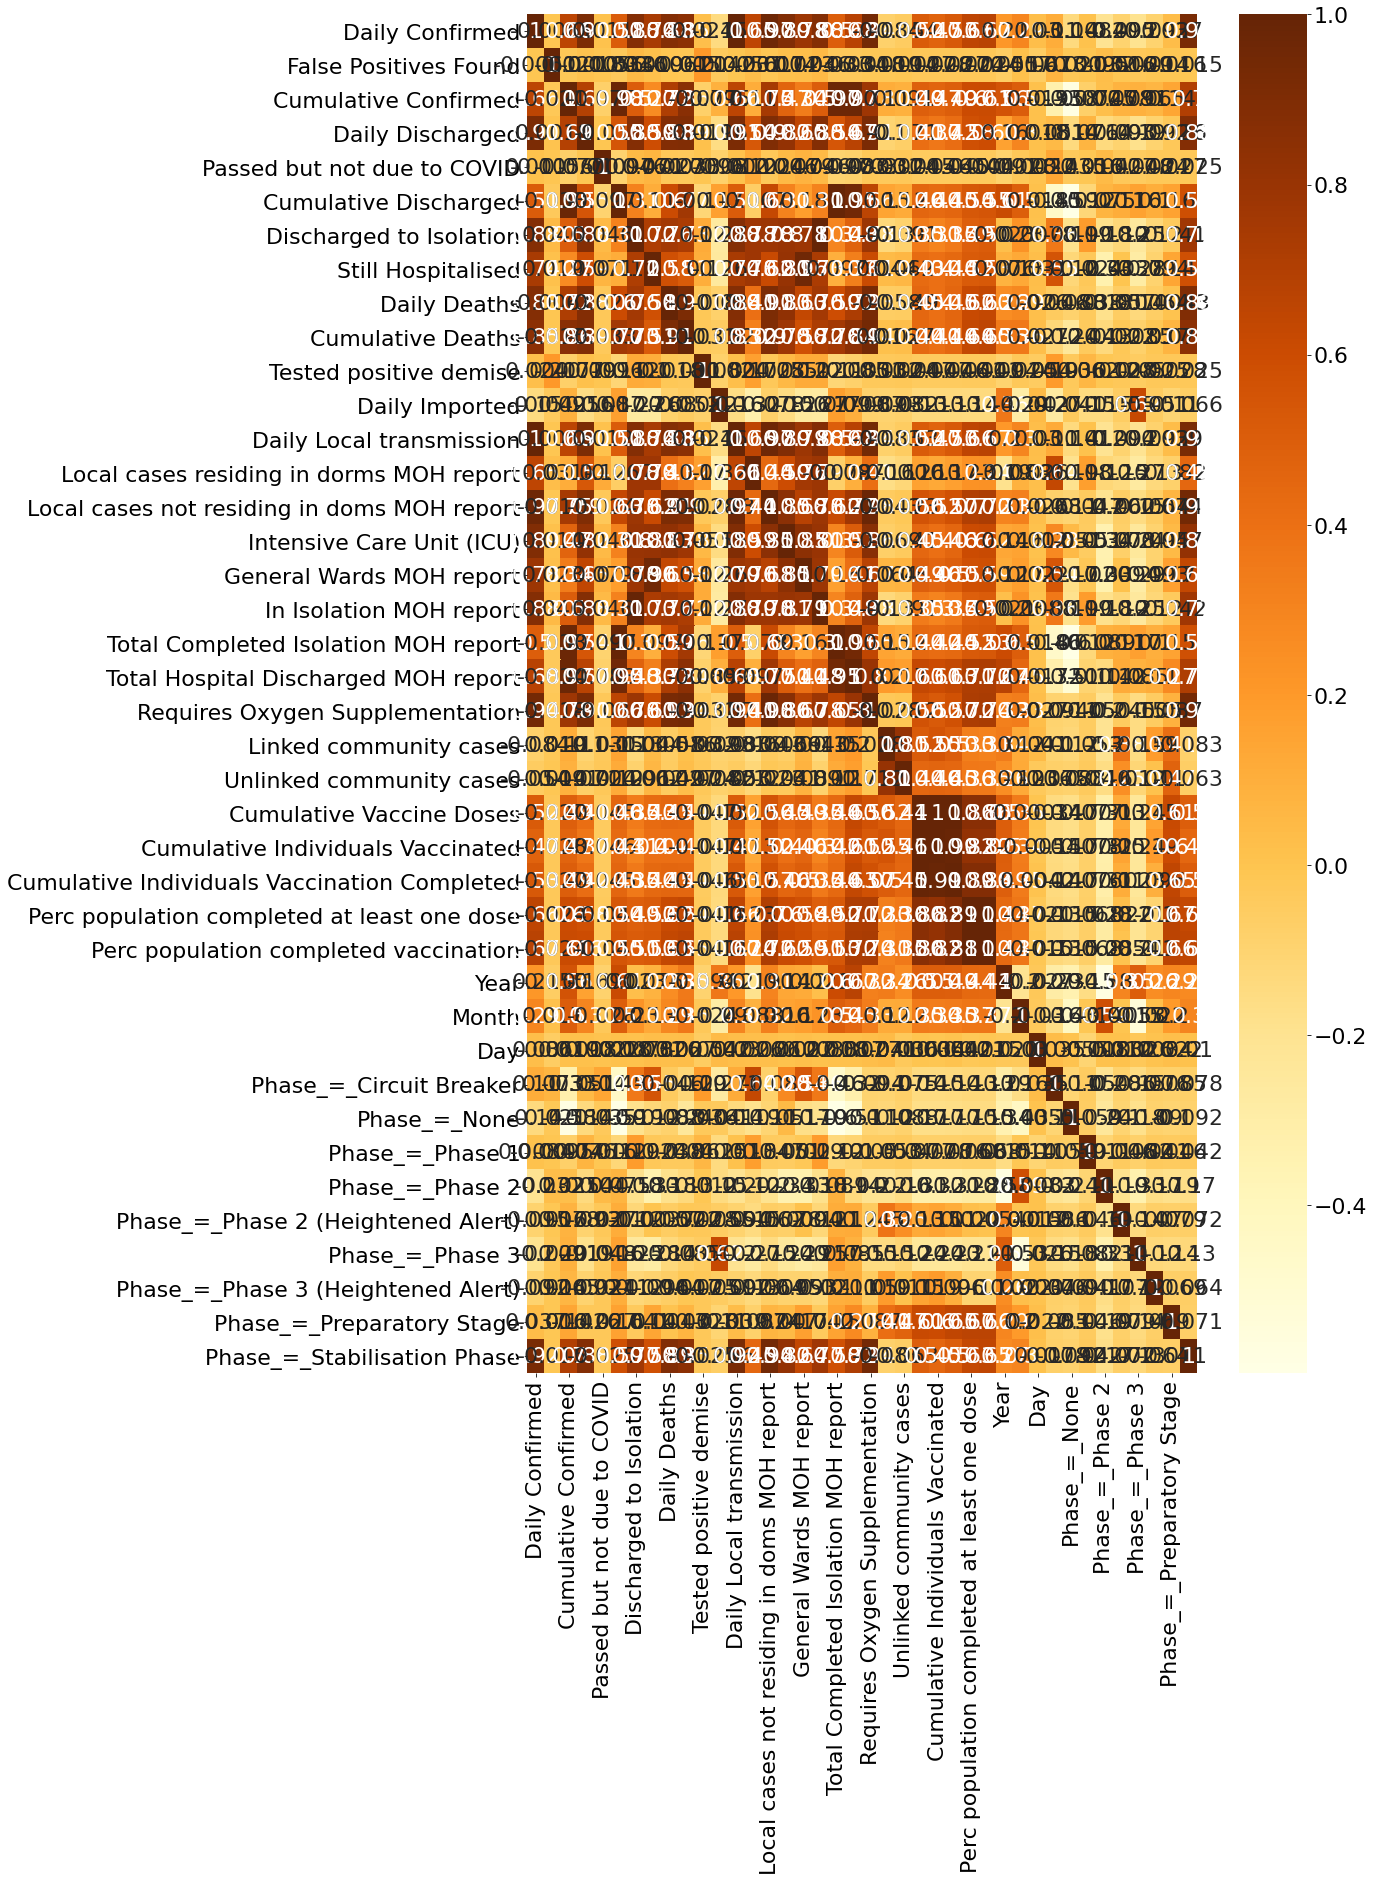

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Confirmed"].sort_values(ascending=False)

Daily Confirmed                                 1.000000
Daily Local transmission                        0.999930
Local cases not residing in doms MOH report     0.967465
Requires Oxygen Supplementation                 0.940776
Phase_=_Stabilisation Phase                     0.923425
Daily Discharged                                0.906742
Intensive Care Unit (ICU)                       0.888460
Daily Deaths                                    0.880983
In Isolation MOH report                         0.880013
Discharged to Isolation                         0.878748
Cumulative Deaths                               0.847099
General Wards MOH report                        0.783910
Still Hospitalised                              0.739267
Total Hospital Discharged MOH report            0.677971
Perc population completed vaccination           0.674367
Cumulative Confirmed                            0.660488
Perc population completed at least one dose     0.655623
Local cases residing in dorms M

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Viewing Chart Pattern

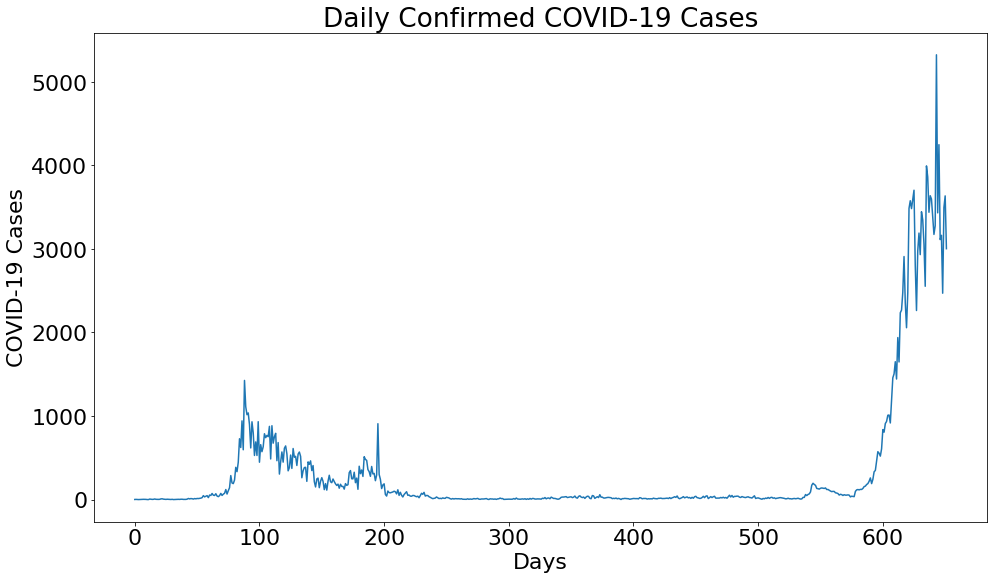

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
sg_data_filtered["Daily Confirmed"].plot()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()
#fig.savefig('Daily_Confirmed_COVID-19_Cases.png')

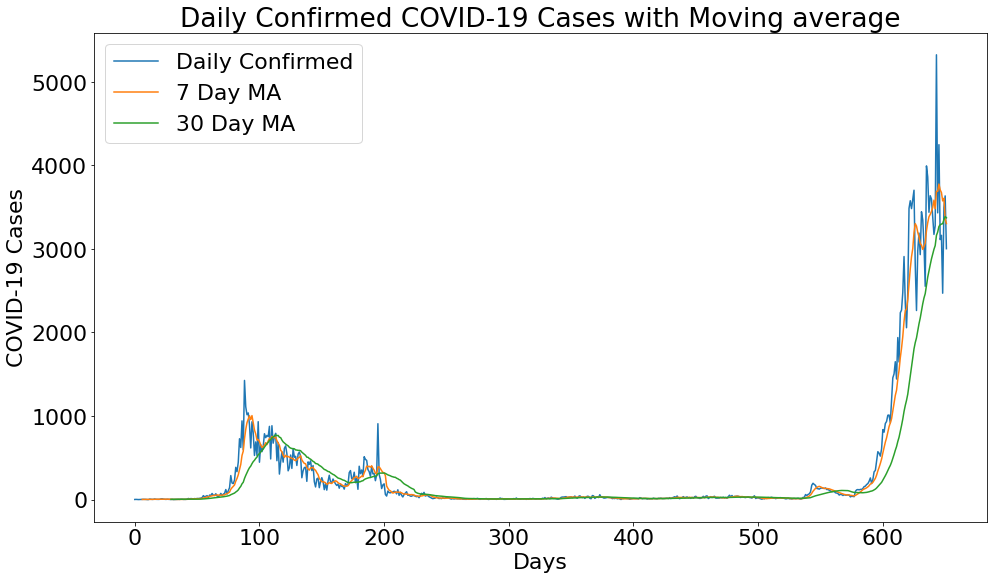

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(sg_data_filtered["Daily Confirmed"], label="Daily Confirmed")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=7).mean(), label="7 Day MA")
ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="30 Day MA")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases with Moving average')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()
#fig.savefig('Daily_Confirmed_COVID-19_Cases_with_Moving_average.png')

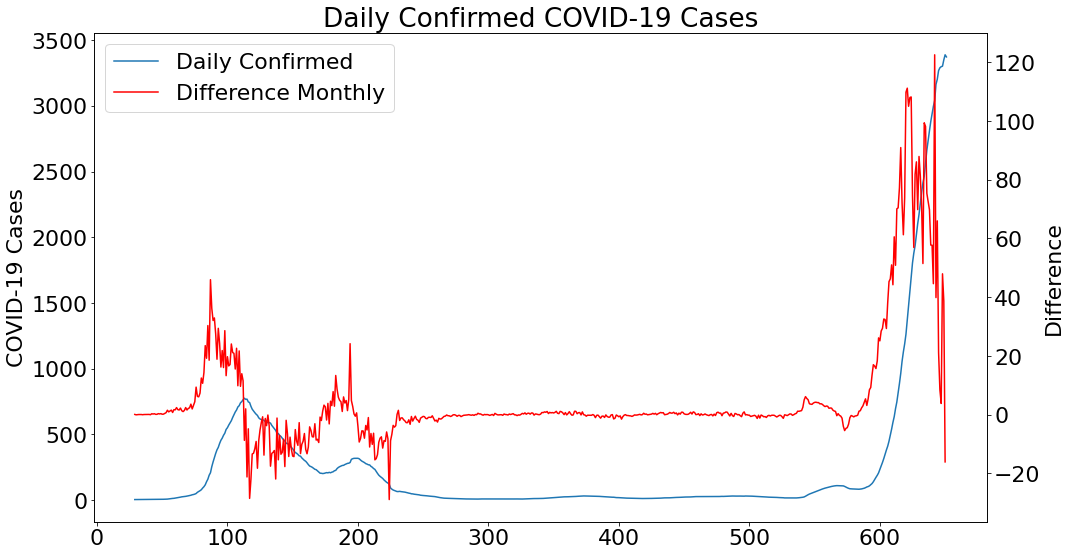

In [22]:
# shows inflection point
fig, ax = plt.subplots(figsize=(16,9))
ln1 = ax.plot(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean(), label="Daily Confirmed")
ax.set_ylabel("COVID-19 Cases")
ax2 = ax.twinx()
ln2 = ax2.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Difference Monthly",color='red')
ax2.set_ylabel("Difference")
ax.legend(ln1+ln2,[x.get_label() for x in (ln1+ln2)])
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.show()
#fig.savefig('Daily_Confirmed_COVID-19_Cases_diff.png')

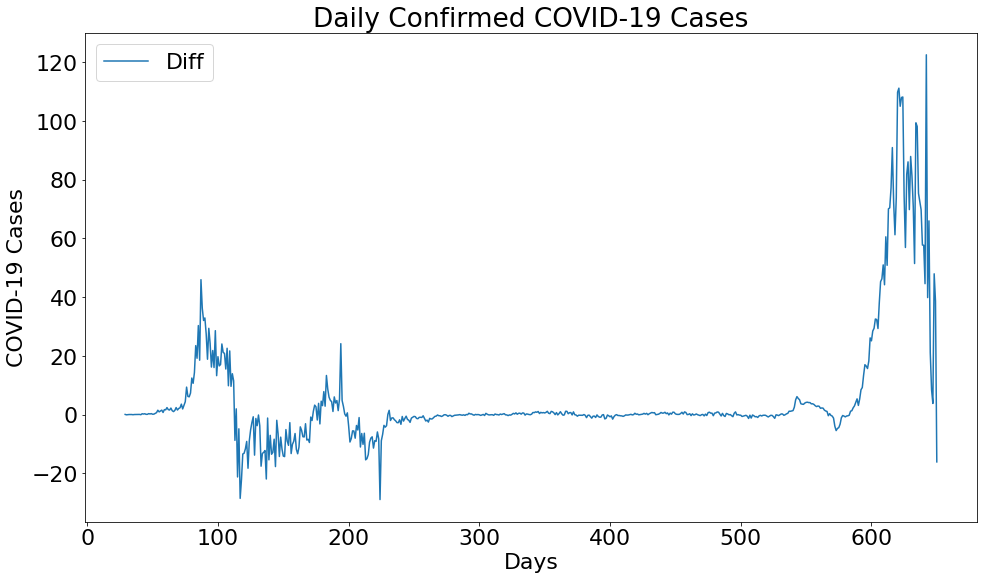

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.diff(sg_data_filtered["Daily Confirmed"].rolling(window=30).mean()), label="Diff")
ax.legend()
plt.title('Daily Confirmed COVID-19 Cases')
plt.xlabel('Days')
plt.ylabel('COVID-19 Cases')
plt.show()


# Train Test Split & KFold Cross Validation

In [24]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Confirmed", axis=1)
y = sg_data_filtered["Daily Confirmed"]

In [25]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:

# strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [27]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [28]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for LR
MAE: 3.6877396603915236e-10
MSE: 3.3453500922937136e-19
RMSE: 5.783900148078037e-10
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


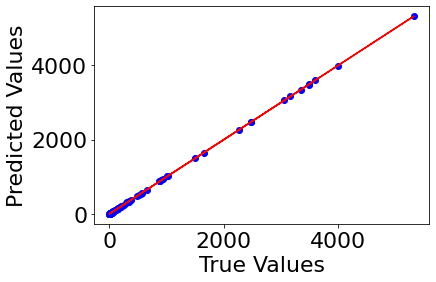

In [29]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

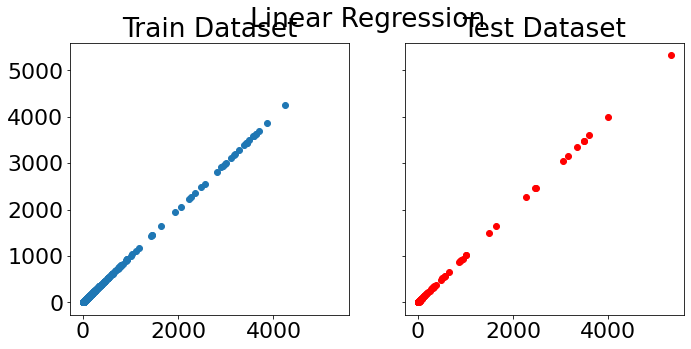

In [30]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [31]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
10,Daily Imported,1.000000e+00
11,Daily Local transmission,1.000000e+00
3,Passed but not due to COVID,8.695254e-10
9,Tested positive demise,8.372314e-10
1,Cumulative Confirmed,3.124461e-10
13,Local cases not residing in doms MOH report,4.472049e-11
12,Local cases residing in dorms MOH report,4.246773e-11
7,Daily Deaths,1.506507e-11
16,In Isolation MOH report,1.248597e-11
14,Intensive Care Unit (ICU),1.217786e-11


# Ridge Regression

In [32]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54035e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [33]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.00047554056053041374
MSE: 2.0091253920743434e-06
RMSE: 0.001417436203881622
R-squared score for train: 0.9999999999982631
Adjusted R-squared score for train: 0.9999999999981524
R-squared score for test: 0.9999999999977901
Adjusted R-squared score for test: 0.9999999999976493
Cross Validation Score: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54035e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.26655e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.90374e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.99256e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.99657e-17): result may not be accurate

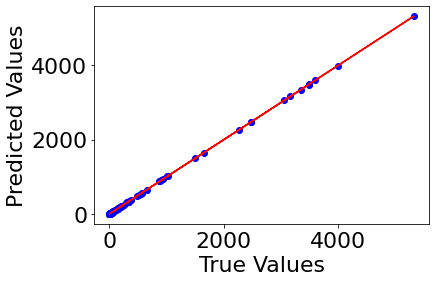

In [34]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

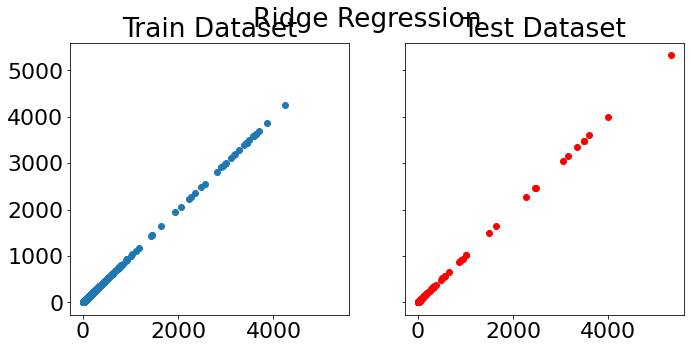

In [35]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [36]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
10,Daily Imported,9.999901e-01
11,Daily Local transmission,9.995321e-01
31,Phase_=_None,1.898063e-03
27,Year,5.299778e-04
13,Local cases not residing in doms MOH report,4.678634e-04
12,Local cases residing in dorms MOH report,4.672187e-04
1,Cumulative Confirmed,1.583556e-04
35,Phase_=_Phase 3,1.063884e-04
14,Intensive Care Unit (ICU),7.220041e-05
28,Month,6.852000e-05


# Important Features & Future Prediction

In [37]:
important_X = X[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train = X_train[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test = X_test[["Daily Imported","Daily Local transmission","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [38]:
# training the model based on the few features extracted
impt_ridge = Ridge()
impt_ridge.fit(important_X_train, y_train)
impt_ridge_pred = impt_ridge.predict(important_X_test)

In [39]:
# evaluating the new model with few select features
impt_train_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
impt_test_adjusted_r2 = 1 - (1-impt_ridge.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, impt_ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, impt_ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, impt_ridge_pred))}")
print(f"R-squared score for train: {impt_ridge.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {impt_train_adjusted_r2}")
print(f"R-squared score for test: {impt_ridge.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {impt_test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(impt_ridge, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for Ridge
MAE: 0.00022235409817813068
MSE: 1.3813738769844025e-07
RMSE: 0.00037166838404475603
R-squared score for train: 0.9999999999998357
Adjusted R-squared score for train: 0.999999999999832
R-squared score for test: 0.999999999999848
Adjusted R-squared score for test: 0.9999999999998447
Cross Validation Score: 1.0


# XGBoost

In [40]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X, y)
xgb_search.best_params_

{'subsample': 0.7,
 'min_child_weight': 4,
 'max_depth': 10,
 'colsample_bytree': 0.9}

In [41]:
xgb = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.7, max_depth=10, colsample_bytree=0.9, min_child_weight=4)
xgb.fit(important_X_train, y_train)
xgb_pred = xgb.predict(important_X_test)
train_adjusted_r2 = 1 - (1-xgb.score(important_X_train, y_train)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
test_adjusted_r2 = 1 - (1-xgb.score(important_X_test, y_test)) * (len(y)-1)/(len(y)-important_X.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred))}")
print(f"R-squared score for train: {xgb.score(important_X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {xgb.score(important_X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 21.057236538133548
MSE: 17676.517079971858
RMSE: 132.95306344711227
R-squared score for train: 0.9993559703304045
Adjusted R-squared score for train: 0.9993418158321716
R-squared score for test: 0.9805567831725925
Adjusted R-squared score for test: 0.9801294597258363
Cross Validation Score: 0.9951


# Prediction with XGBoost

In [42]:
future_prediction = pd.DataFrame(data={
    "Daily Imported":[0],
    "Daily Local transmission":[5000],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred = xgb.predict(future_prediction)

xgb_fut_pred
# total cases in SG of 3720 but does not make sense because daily local transmission is 5000
# no worries bout the numbers because there were only a few days of 5k cases

array([3834.6785], dtype=float32)

# XGBoost Without Daily Local Transmission

In [43]:
important_X_wo = X[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_train_wo = X_train[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()
important_X_test_wo = X_test[["Daily Imported","Year","Month","Day","Phase_=_Preparatory Stage","Phase_=_Phase 3 (Heightened Alert)","Phase_=_Phase 2","Phase_=_Stabilisation Phase","Phase_=_Phase 1","Phase_=_Phase 3","Phase_=_Phase 2 (Heightened Alert)","Phase_=_None","Phase_=_Circuit Breaker"]].copy()

In [44]:
# XGBoost

xgb_param = XGBRegressor()
xgb_params = dict()
xgb_params["max_depth"] = [3, 4, 5, 8, 10]
xgb_params["subsample"] = [0.7, 0.8, 0.9]
xgb_params["colsample_bytree"] = [0.7, 0.8, 0.9]
xgb_params["min_child_weight"] = [2, 4, 6]

xgb_search = RandomizedSearchCV(xgb_param, xgb_params, n_jobs=-1, cv=KFold(n_splits=5, shuffle=True, random_state=42))
xgb_search.fit(important_X_wo, y)
xgb_search.best_params_

{'subsample': 0.9,
 'min_child_weight': 4,
 'max_depth': 4,
 'colsample_bytree': 0.9}

In [45]:
xgb2 = XGBRegressor(learning_rate=0.03, n_estimators=300, subsample=0.9, max_depth=4, colsample_bytree=0.9, min_child_weight=4)
xgb2.fit(important_X_train_wo, y_train)
xgb_pred_wo = xgb2.predict(important_X_test_wo)
train_adjusted_r2_wo = 1 - (1-xgb2.score(important_X_train_wo, y_train)) * (len(y)-1)/(len(y)-important_X_wo.shape[1]-1)
test_adjusted_r2_wo = 1 - (1-xgb2.score(important_X_test_wo, y_test)) * (len(y)-1)/(len(y)-important_X_wo.shape[1]-1)
print("Evaluation Metrics for XGBoost")
print(f"MAE: {mean_absolute_error(y_test, xgb_pred_wo)}")
print(f"MSE: {mean_squared_error(y_test, xgb_pred_wo)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_pred_wo))}")
print(f"R-squared score for train: {xgb2.score(important_X_train_wo, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2_wo}")
print(f"R-squared score for test: {xgb2.score(important_X_test_wo, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2_wo}")
# print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb, important_X, y, cv=5)), 4)}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(xgb2, important_X_wo, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))), 4)}")

Evaluation Metrics for XGBoost
MAE: 100.80930093044543
MSE: 56706.284298568535
RMSE: 238.1308134168456
R-squared score for train: 0.98426199231805
Adjusted R-squared score for train: 0.9839413119107375
R-squared score for test: 0.9376261411619989
Adjusted R-squared score for test: 0.9363552004646729
Cross Validation Score: 0.953


In [46]:
future_prediction_wo = pd.DataFrame(data={
    "Daily Imported":[12],
    "Year":[2021],
    "Month":[12],
    "Day":[14],
    "Phase_=_Preparatory Stage":[0],
    "Phase_=_Phase 3 (Heightened Alert)":[0],
    "Phase_=_Phase 2":[0],
    "Phase_=_Stabilisation Phase":[1],
    "Phase_=_Phase 1":[0],
    "Phase_=_Phase 3":[0],
    "Phase_=_Phase 2 (Heightened Alert)":[0],
    "Phase_=_None":[0],
    "Phase_=_Circuit Breaker":[0]
})

xgb_fut_pred_wo = xgb2.predict(future_prediction_wo)

xgb_fut_pred_wo

array([3204.852], dtype=float32)